In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from oma_clustering.oma_clustering_hdbscan import ModeClusterer_HDBSCAN
from oma_clustering.clustering_plots import generate_colormap
import datetime
import os
import pandas as pd
#import utc
import pytz
from pytz import utc
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Get the data
PROJECT_PATH = os.path.dirname(os.path.dirname(os.getcwd()))
data_path = os.path.join(PROJECT_PATH, 'data', 'OMA_7.parquet') # Change to local data path
start = datetime.datetime(2022, 4, 2, tzinfo=utc)
stop = datetime.datetime(2022, 4, 8, tzinfo=utc)

oma_data = pd.read_parquet(data_path)[start:stop]
sensor = 'mpe_MO_04_ACC3_Z'
sensor_data = pd.DataFrame.from_records(oma_data[sensor].explode().dropna().tolist()).set_index(oma_data[sensor].explode().dropna().index)

In [5]:
sensor_data

,algorithm,damping,frequency,location,mode_shape,name,size,std_damping,std_frequency
timestamp,,,,,,,,,
2022-04-02 00:00:00+00:00,lscf,0.262001,3.885219,None,None,mpe_MO_04_ACC3_Z,81,0.112911,0.003548
2022-04-02 00:00:00+00:00,lscf,0.623528,4.371079,None,None,mpe_MO_04_ACC3_Z,60,0.273884,0.006233
2022-04-02 00:00:00+00:00,lscf,0.191044,4.942809,None,None,mpe_MO_04_ACC3_Z,66,0.073237,0.006016
2022-04-02 00:00:00+00:00,lscf,0.377394,5.766566,None,None,mpe_MO_04_ACC3_Z,31,0.192286,0.004496
2022-04-02 00:00:00+00:00,lscf,0.689008,5.827136,None,None,mpe_MO_04_ACC3_Z,11,0.196872,0.002812
...,...,...,...,...,...,...,...,...,...
2022-04-08 00:00:00+00:00,lscf,0.325924,62.807814,None,None,mpe_MO_04_ACC3_Z,31,0.072157,0.009438
2022-04-08 00:00:00+00:00,lscf,0.036753,63.058741,None,None,mpe_MO_04_ACC3_Z,13,0.019495,0.003254
2022-04-08 00:00:00+00:00,lscf,0.036839,63.111439,None,None,mpe_MO_04_ACC3_Z,12,0.014080,0.004785


In [6]:
mc = ModeClusterer_HDBSCAN(
    min_cluster_size = 100,
    min_samples = 100,
    multipliers = {"frequency": 500, "size": 0.5, "damping": 1},
    index_divider = 20000,
    cols = ['frequency', 'size', 'damping'],
    min_size = 5.0,
    max_damping = 5.0
    )

In [7]:
mc.fit(sensor_data)

In [8]:
clustered_modes = mc.predict(min_cluster_size=200)
clustered_modes = clustered_modes[clustered_modes.labels != -1]
len(clustered_modes.labels.unique())

32

In [9]:
from sklearn.metrics import silhouette_score

# Compute the silhouette score
score = silhouette_score(mc.processed_data, mc.hdbsc.labels_)
score

0.7010282255311815

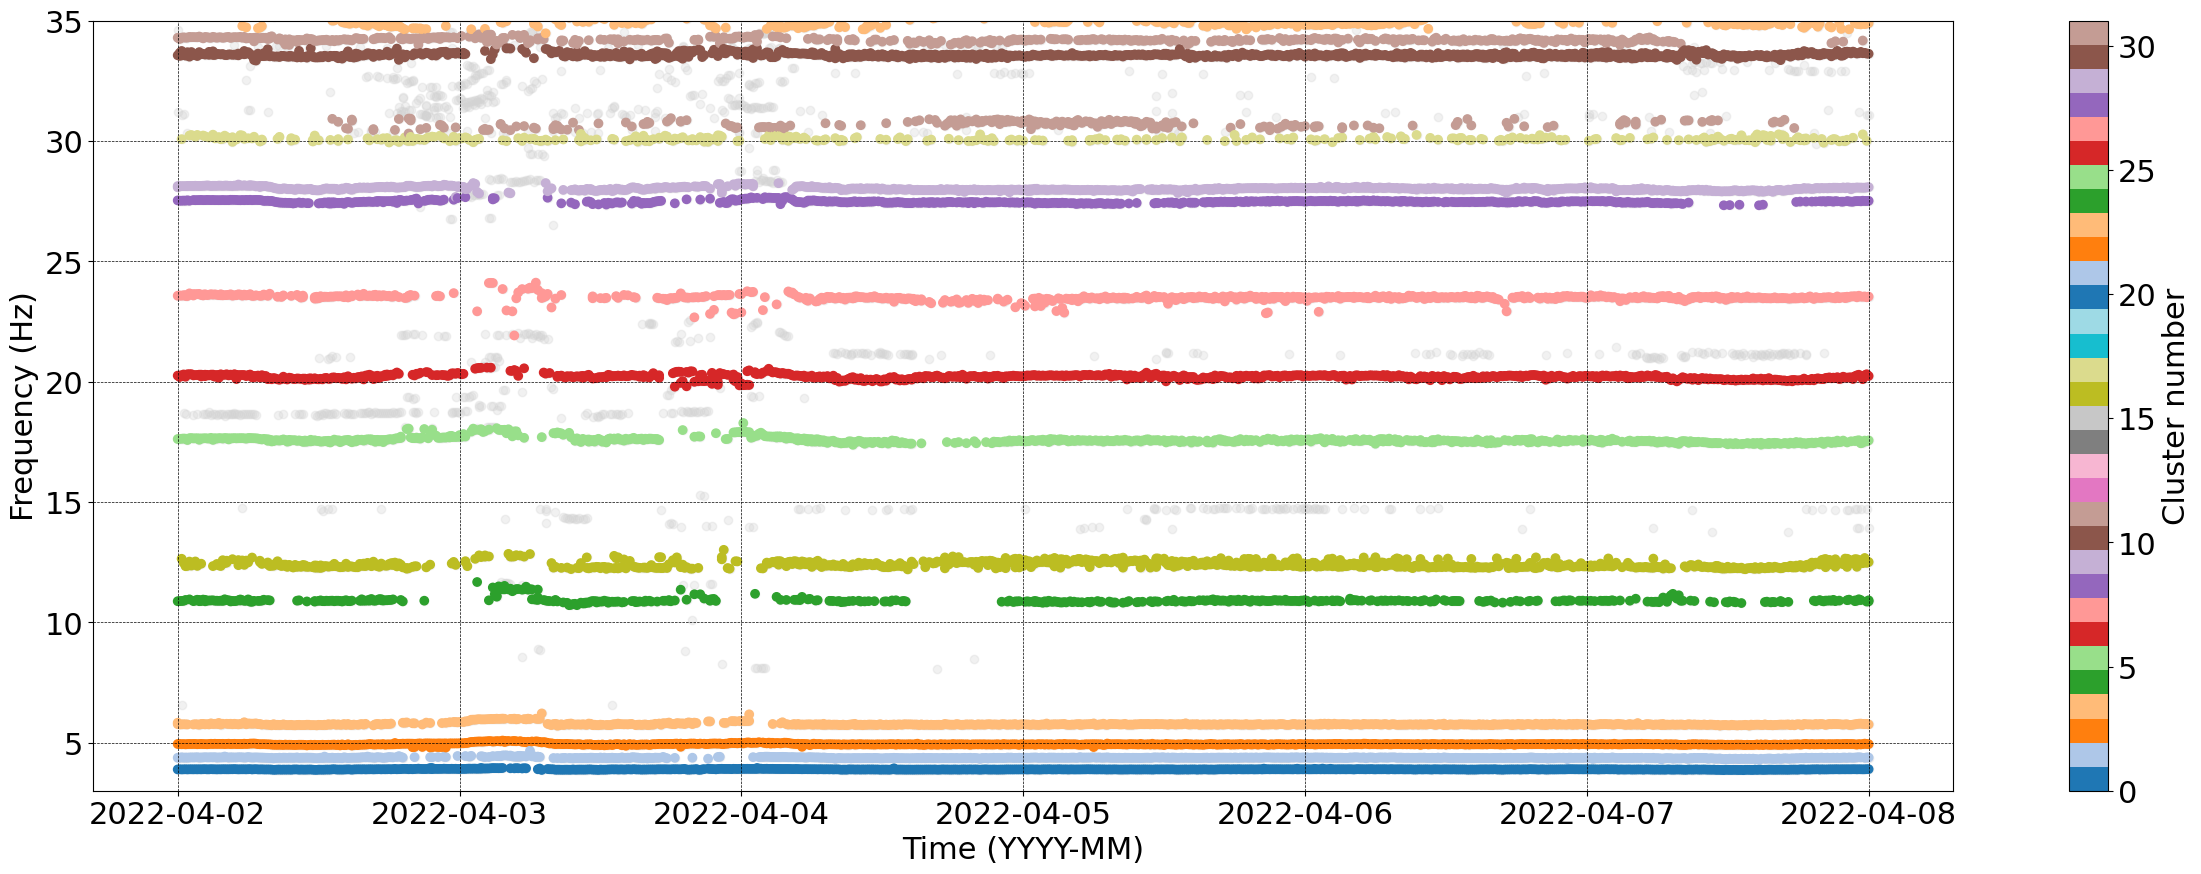

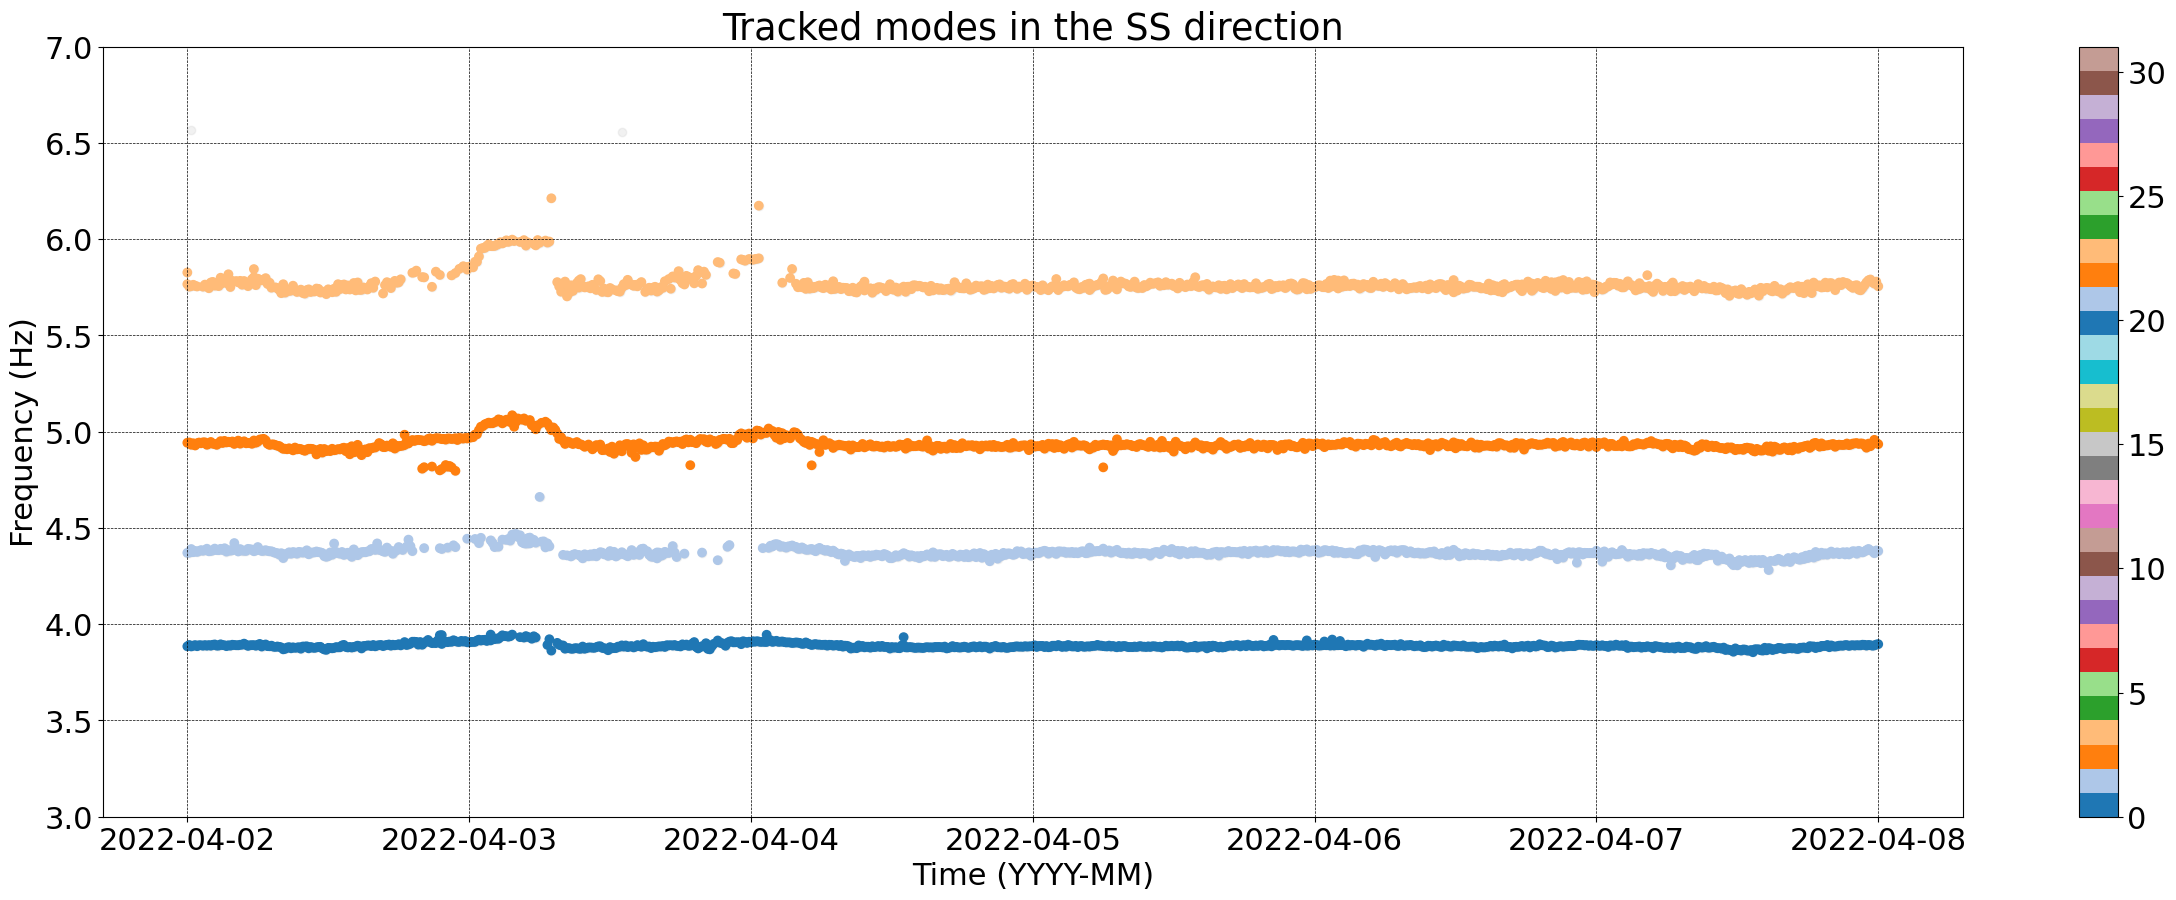

In [10]:
plt.rcParams.update({'font.size': 22})

clustering_data = sensor_data

fig, ax = plt.subplots(figsize = (30,10))

ax.scatter(clustering_data.index, clustering_data['frequency'], alpha=0.3, color='lightgrey')
# Create new colormap
cmap = generate_colormap(len(clustered_modes.labels.unique()))

im = ax.scatter(clustered_modes.index, clustered_modes['frequency'], c=clustered_modes['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(im, ax=ax,label='Cluster number')

plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.ylim(3, 35)
plt.show()

# write figure to figure_path
figure_path = os.path.join(PROJECT_PATH, 'figures', 'clustering', 'OMA7')
fig.savefig(os.path.join(figure_path, 'HDBSCAN_clustering.png'), bbox_inches='tight')

fig, ax = plt.subplots(figsize = (30,10))

ax.scatter(clustering_data.index, clustering_data['frequency'], alpha=0.3, color='lightgrey')
cmap = generate_colormap(len(clustered_modes.labels.unique()))

im = ax.scatter(clustered_modes.index, clustered_modes['frequency'], c=clustered_modes['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(im, ax=ax)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the SS direction')
plt.ylim(3, 7)
plt.show()